# Jina Embeddings v3

Extra datacleaning

### Imports

In [1]:
# # Install necessary libraries if not already installed
# !pip install --upgrade torch torchvision
# !pip install flash-attn --no-build-isolation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import random
import umap
import re
import pandas as pd
import matplotlib.pyplot as plt
import re


## Step 2: Data cleaning 



#### Load data

In [3]:
df_ev = pd.read_csv(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv")
df_ev.head()

,published_time,title,description,content,url,channel
0,2015/01/01,Euro nu ook in Litouwen,Vanaf vandaag betalen ze in Litouwen met de eu...,Euro nu ook in Litouwen In Litouwen wordt vana...,https://nos.nl/artikel/2011341-euro-nu-ook-in-...,nos
1,2015/01/01,Start 2015 vol vreugde maar ook met gewonden e...,Nederland is met oliebollen en vuurwerk het ni...,Start 2015 vol vreugde maar ook met gewonden e...,https://nos.nl/artikel/2011343-start-2015-vol-...,nos
2,2015/01/01,Letland nieuwe voorzitter van de Europese Unie,Vanaf vandaag neemt Letland het stokje over va...,Letland nieuwe voorzitter van de Europese Unie...,https://nos.nl/artikel/2011346-letland-nieuwe-...,nos
3,2015/01/01,Noord-Korea wil praten met Zuid-Korea,De Noord-Koreaanse leider Kim Jong-un zei in z...,Noord-Korea wil praten met Zuid-Korea De Noord...,https://nos.nl/artikel/2011348-noord-korea-wil...,nos
4,2015/01/01,"Feest in Londen, Parijs en Berlijn",In Londen en Berlijn waren muziekfestivals. Pa...,"Feest in Londen, Parijs en Berlijn In Europa i...",https://nos.nl/artikel/2011351-feest-in-londen...,nos


Woorden en carracters tellen voor en na de cleaning

voor embedding cleaning 

In [4]:
# Combine 'title', 'description', and 'content' into 'combined_text'
df_ev['combined_text'] = df_ev['title'].fillna('') + ". " + df_ev['description'].fillna('') + ". " + df_ev['content'].fillna('')

# Bereken het totale aantal karakters in 'combined_text'
total_characters = df_ev['combined_text'].str.len().sum()
print(f"Totaal aantal karakters in 'combined_text': {total_characters}")

# Bereken de grootte van de CSV in megabytes
csv_size_mb = df_ev.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Grootte van de CSV: {csv_size_mb:.2f} MB")

Totaal aantal karakters in 'combined_text': 768792152
Grootte van de CSV: 2260.17 MB


Text cleaning

* evt nog stop woorden verwijderen zoals ik etc 

In [5]:


# Define the text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[\/\-']", ' ', text)
    text = re.sub(r"&", ' and ', text)
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Apply the cleaning function to the 'combined_text' column
df_ev['combined_text'] = df_ev['combined_text'].apply(clean_text)

# Recalculate the total number of characters in 'combined_text'
total_characters_cleaned = df_ev['combined_text'].str.len().sum()
print(f"Totaal aantal karakters na schoonmaken: {total_characters_cleaned}")

# Recalculate the size of the CSV in megabytes
csv_size_mb_cleaned = df_ev.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Grootte van de CSV na schoonmaken: {csv_size_mb_cleaned:.2f} MB")

Totaal aantal karakters na schoonmaken: 749908840
Grootte van de CSV na schoonmaken: 1898.18 MB


oke dit heeft niet veel verschil gemaakt, wil nu keyword search doen voordat ik ga embedden

Totaal aantal karakters in EV-gerelateerde artikelen: 17197163
Grootte van de CSV met EV-gerelateerde artikelen: 46.78 MB

Aantal artikelen per kanaal (EV-gerelateerd):
channel
nos          3301
nieuwsuur     315
Name: count, dtype: int64


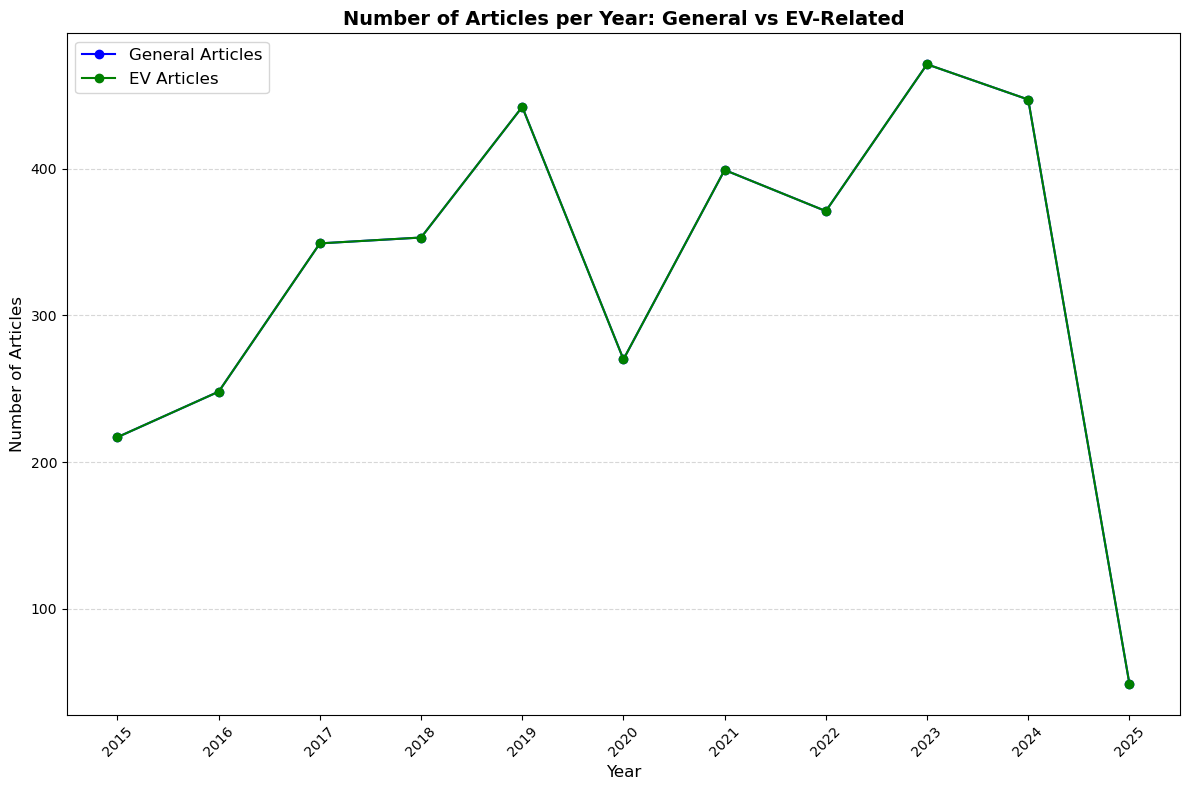

EV-related articles exported to: E:\Nieuw dataset\EV_related_articles.csv
Gemiddeld aantal EV-gerelateerde artikelen per maand: 27.39


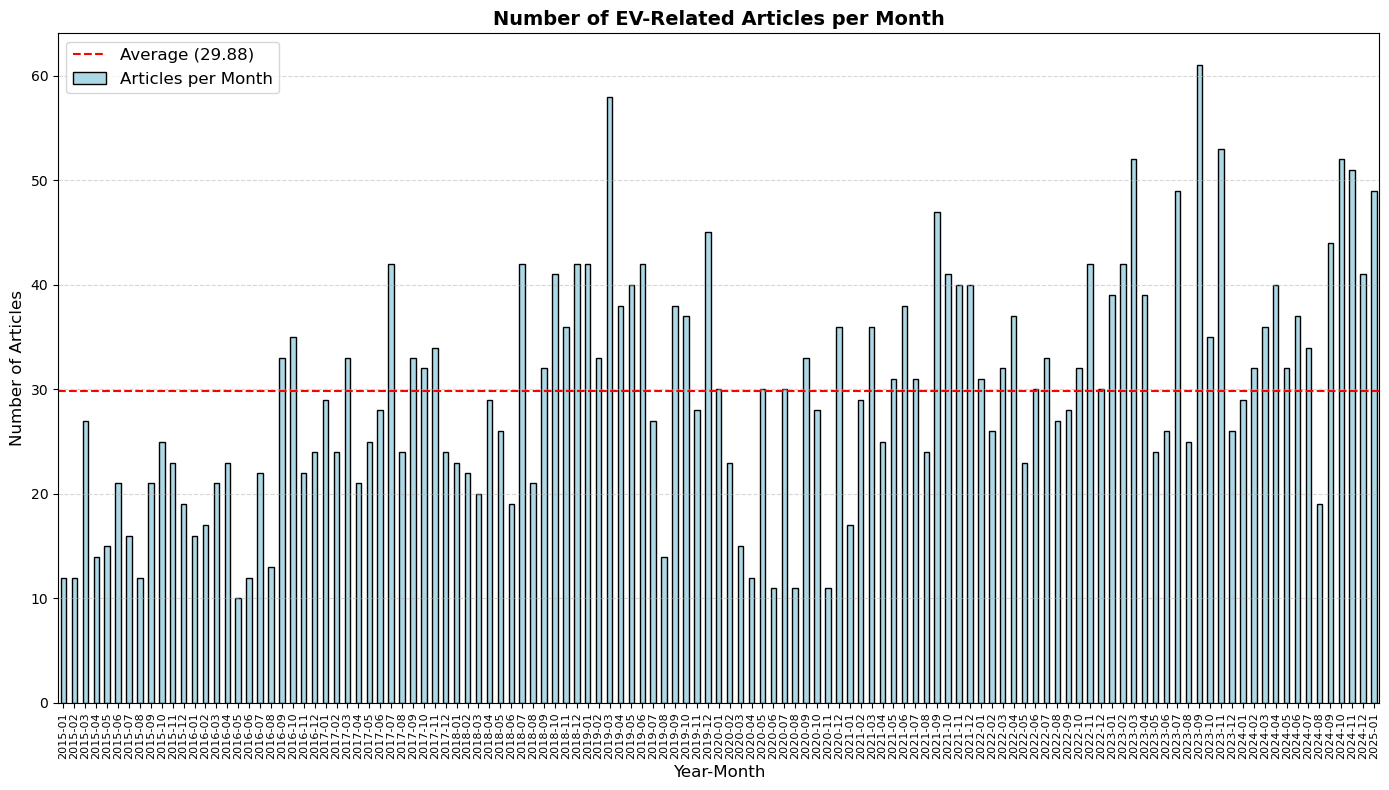

Missing months for general articles:
PeriodIndex(['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-12',
             '2016-02', '2016-03', '2016-05', '2016-06', '2016-07', '2016-08',
             '2016-10', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
             '2017-06', '2017-07', '2017-08', '2017-11', '2017-12', '2018-01',
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-08', '2018-09',
             '2018-10', '2018-11', '2019-01', '2019-02', '2019-03', '2019-04',
             '2019-06', '2019-08', '2019-09', '2019-11', '2019-12', '2020-02',
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-08', '2020-09',
             '2020-11', '2020-12', '2021-01', '2021-02'],
            dtype='period[M]')

Missing months for EV-related articles:
PeriodIndex(['2015-07', '2020-05', '2020-08', '2020-11', '2021-02'], dtype='period[M]')


In [136]:

# Definieer de lijst van EV-gerelateerde keywords
ev_keywords = [
    "elektrische auto", "elektrische voertuigen", "elektrisch rijden", "stekkerauto", "emissievrij",
    "zero emission", "elektrisch vervoer", "battery electric vehicle", " BEV ", " EV", "EV-markt",
    "laadpaal", "laadinfrastructuur", "laadstation", "snelladen", "laadtijd",
    "laadnetwerk", "opladen", "elektriciteitsnet", "netcongestie",
    "batterij", "accu", "actieradius", "solid state batterij", "energieopslag", "accutechnologie",
    "Tesla", " BYD ", "Volkswagen ID", "Renault Zoe", "Hyundai Ioniq", "Kia EV",
    "Nissan Leaf", "Polestar", "BMW i", "Ford Mustang Mach-E", "Audi e-tron",
    "subsidie elektrische auto", "aanschafsubsidie", "bijtelling",
    "fiscale stimulering", "milieu-investeringsaftrek", "overheidsbeleid", "klimaatmaatregelen",
    "duurzame mobiliteit", "klimaatbeleid", "CO2-uitstoot", "groene transitie",
    "verduurzaming vervoer", "energietransitie", "schoner verkeer",
    "tweedehands elektrische auto", "EV import", "EV export", "restwaarde EV",
    "autoverkoop EV", "EV occasion", "elektrisch leasen", "Subsidieregeling Elektrische Personenauto's Particulieren"
]

# Maak regex patroon: \b staat voor woordgrenzen
ev_pattern = r'\b(?:' + '|'.join(re.escape(kw) for kw in ev_keywords) + r')\b'

# Filter de DataFrame met behulp van regex (één of meer keywords)
ev_mask = df_ev['combined_text'].str.contains(ev_pattern, case=False, na=False, regex=True)
df_ev = df_ev[ev_mask].copy()

# Herbereken aantal karakters en grootte
total_characters_ev = df_ev['combined_text'].str.len().sum()
csv_size_mb_ev = df_ev.memory_usage(deep=True).sum() / (1024 * 1024)

# Print resultaten
print(f"Totaal aantal karakters in EV-gerelateerde artikelen: {total_characters_ev}")
print(f"Grootte van de CSV met EV-gerelateerde artikelen: {csv_size_mb_ev:.2f} MB")

# Aantal artikelen per kanaal
channel_counts_ev = df_ev['channel'].value_counts()
print("\nAantal artikelen per kanaal (EV-gerelateerd):")
print(channel_counts_ev)

# Voeg jaartal toe aan beide DataFrames
df_ev['year'] = pd.to_datetime(df_ev['published_time'], errors='coerce').dt.year
df_ev['year'] = pd.to_datetime(df_ev['published_time'], errors='coerce').dt.year

# Tel artikelen per jaar
articles_per_year = df_ev['year'].value_counts().sort_index()
ev_articles_per_year = df_ev['year'].value_counts().sort_index()

# Zorg dat jaren gesynchroniseerd zijn
all_years = sorted(set(articles_per_year.index).union(ev_articles_per_year.index))
articles_per_year = articles_per_year.reindex(all_years, fill_value=0)
ev_articles_per_year = ev_articles_per_year.reindex(all_years, fill_value=0)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(all_years, articles_per_year, label="General Articles", marker='o', color='blue')
plt.plot(all_years, ev_articles_per_year, label="EV Articles", marker='o', color='green')
plt.title("Number of Articles per Year: General vs EV-Related", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(all_years, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Exporteer naar CSV
output_path = r"E:\Nieuw dataset\EV_related_articles.csv"
df_ev.to_csv(output_path, index=False, encoding='utf-8')
print(f"EV-related articles exported to: {output_path}")

# Gemiddeld per maand
average_ev_articles_per_month = ev_articles_per_year.sum() / (len(ev_articles_per_year) * 12)
print(f"Gemiddeld aantal EV-gerelateerde artikelen per maand: {average_ev_articles_per_month:.2f}")

# Ensure 'published_time' is in datetime format
df_ev['published_time'] = pd.to_datetime(df_ev['published_time'], errors='coerce')

# Extract year and month from 'published_time'
df_ev['year_month'] = df_ev['published_time'].dt.to_period('M')

# Count the number of articles per month
articles_per_month = df_ev['year_month'].value_counts().sort_index()

# Calculate the average number of articles per month
average_articles_per_month = articles_per_month.mean()

# Plot the data
plt.figure(figsize=(14, 8))
articles_per_month.plot(kind='bar', color='lightblue', edgecolor='black', label="Articles per Month")

# Add a horizontal line for the average
plt.axhline(y=average_articles_per_month, color='red', linestyle='--', label=f"Average ({average_articles_per_month:.2f})")

# Add labels, title, and formatting
plt.title("Number of EV-Related Articles per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


# Print missing months for general articles
print("Missing months for general articles:")
print(missing_months)

# Print missing months for EV-related articles
print("\nMissing months for EV-related articles:")
print(missing_months_ev)

In [137]:
import pandas as pd

# Load the dataset
file_path = r"E:\Nieuw dataset\EV_related_articles.csv"
df = pd.read_csv(file_path)

# Ensure 'published_time' is in datetime format
df['published_time'] = pd.to_datetime(df['published_time'], errors='coerce')

# Extract year and month from 'published_time'
df['year_month'] = df['published_time'].dt.to_period('M')

# Identify all months between the first and last publication
all_months = pd.period_range(start=df['year_month'].min(), end=df['year_month'].max(), freq='M')

# Identify months with articles
valid_months = df['year_month']

# Determine missing months
missing_months = all_months.difference(valid_months)

# Print missing months
print("Missing months:")
print(missing_months)

# Calculate percentage of missing months
total_months = len(all_months)
missing_months_percentage = (len(missing_months) / total_months) * 100
print(f"Percentage of missing months: {missing_months_percentage:.2f}%")

Missing months:
PeriodIndex([], dtype='period[M]')
Percentage of missing months: 0.00%


In [135]:
# Filter EV-related articles
ev_related_articles = sorted_df[sorted_df['ev_related']]

# Convert 'published_time' to datetime format
ev_related_articles['published_time'] = pd.to_datetime(ev_related_articles['published_time'], errors='coerce')

# Extract year and month from 'published_time'
ev_related_articles['year_month'] = ev_related_articles['published_time'].dt.to_period('M')

# Identify all months between the first and last publication
all_months_ev = pd.period_range(start=ev_related_articles['year_month'].min(), 
                                end=ev_related_articles['year_month'].max(), freq='M')

# Identify months with EV-related articles
valid_months_ev = ev_related_articles['year_month']

# Determine missing months
missing_months_ev = all_months_ev.difference(valid_months_ev)

# Print missing months
print("Missing months (EV-related):")
print(missing_months_ev)

# Calculate total number of EV-related articles
total_ev_articles = len(ev_related_articles)

# Print total number of EV-related articles
print(f"Total EV-related articles: {total_ev_articles}")

Missing months (EV-related):
PeriodIndex(['2015-07', '2020-05', '2020-08', '2020-11', '2021-02'], dtype='period[M]')
Total EV-related articles: 261


C:\Users\dylan\AppData\Local\Temp\ipykernel_4664\929494282.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_related_articles['published_time'] = pd.to_datetime(ev_related_articles['published_time'], errors='coerce')
C:\Users\dylan\AppData\Local\Temp\ipykernel_4664\929494282.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_related_articles['year_month'] = ev_related_articles['published_time'].dt.to_period('M')


In [70]:

# Display 10 random titles and URLs from the EV-related articles DataFrame
random_articles = df_ev.sample(10, random_state=42)[['title', 'url']]

# Print the titles, URLs, and matching keywords
for index, row in random_articles.iterrows():
    title = row['title']
    url = row['url']
    # Access 'combined_text' from the original df_ev DataFrame using the index
    full_text = df_ev.loc[index, 'combined_text']
    
    matching_keywords = [kw for kw in ev_keywords if kw.lower() in full_text.lower()]
    
    print(f"Title: {title}")
    print(f"URL: {url}")
    print(f"Matching Keywords: {', '.join(matching_keywords) if matching_keywords else 'None'}\n")

random_articles = df_ev.sample(10, random_state=42)[['title', 'url']]

# Print the titles, URLs, and matching keywords
for index, row in random_articles.iterrows():
    title = row['title']
    url = row['url']
    matching_keywords = [keyword for keyword in ev_keywords if keyword.lower() in title.lower()]
    
    print(f"Title: {title}")
    print(f"URL: {url}")
    print(f"Matching Keywords: {', '.join(matching_keywords) if matching_keywords else 'None'}\n")

Title: Veel meer elektrische auto's aan boord van brandend schip dan gedacht: 498
URL: https://nos.nl/artikel/2484547-veel-meer-elektrische-auto-s-aan-boord-van-brandend-schip-dan-gedacht-498
Matching Keywords: accu, elektrisch

Title: Boeren vs. burgers, mobiliteit en woningnood: provinciale politici in gesprek 
URL: https://nos.nl/artikel/2275549-boeren-vs-burgers-mobiliteit-en-woningnood-provinciale-politici-in-gesprek
Matching Keywords: subsidie

Title: Raster onder stroom moet grutto's Groningen beschermen tegen zwemmende vossen
URL: https://nos.nl/artikel/2471994-raster-onder-stroom-moet-grutto-s-groningen-beschermen-tegen-zwemmende-vossen
Matching Keywords: accu

Title: Huizen, auto's, industrie: 'Forse extra inspanning nodig voor Nederlands klimaatbeleid'
URL: https://nos.nl/artikel/2399019-huizen-auto-s-industrie-forse-extra-inspanning-nodig-voor-nederlands-klimaatbeleid
Matching Keywords: elektrisch

Title: Campagneblog: Ploumen (PvdA) en Kaag (D66) vinden elkaar • Geen OMT-a

 ## Jina Embeddings V3

#### Superkleine batch draaien

In [8]:
import numpy as np

# Laad de embeddings
embeddings = np.load(r"E:\Nieuw dataset\jina_embeddings.npy")


print(embeddings.shape)  #

(2145, 1024)


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)


# Laad de embeddings
embeddings = np.load(r"E:\Nieuw dataset\jina_embeddings.npy")

In [67]:
# Define a query specifically about electric cars
electric_cars_query = (
    "Nieuws over elektrische auto's",
    "Artikelen over laadpalen, elektrisch rijden, en subsidies voor elektrische voertuigen.",
    "Informatie over elektrische voertuigen, laadstations, en duurzame mobiliteit.",
    "Zoek naar nieuws over Tesla, en emissievrij vervoer.",
    "Elektrische auto's, accutechnologie, en energietransitie in het nieuws."
)

# Generate an embedding for the query
electric_cars_query_embedding = model.encode(electric_cars_query, task='retrieval.query').mean(axis=0)

# Calculate cosine similarity between the query embedding and the article embeddings
electric_cars_similarities = cosine_similarity([electric_cars_query_embedding], embeddings)[0]

# Ensure the length of electric_cars_similarities matches the subset of df_ev used for embeddings
df_ev_subset = df_ev.iloc[:len(electric_cars_similarities)].copy()

# Add similarity scores to the subset DataFrame
df_ev_subset['similarity'] = electric_cars_similarities

# Label articles as 'ev_related' based on a similarity threshold
similarity_threshold = 0.35
df_ev_subset['ev_related'] = df_ev_subset['similarity'] >= similarity_threshold

# Sort the DataFrame by similarity in descending order
sorted_articles = df_ev_subset.sort_values(by='similarity', ascending=False).copy()

# Save the sorted DataFrame with similarity scores to a CSV file
output_path = r"E:\Nieuw dataset\sorted_ev_articles_with_similarity.csv"
sorted_articles.to_csv(output_path, index=False, encoding='utf-8')
print(f"Sorted articles with similarity scores saved to: {output_path}")

# Display the top 10 most relevant articles
print("Top 10 articles about electric cars:")
for idx, row in sorted_articles.head(10).iterrows():
    print(f"\nArticle {idx} similarity: {row['similarity']:.4f}")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Content (snippet): {row['content'][:200]}...")
    print(f"URL: {row['url']}")
    # Print the related keywords for each article
    print(f"Related Keywords: {', '.join([kw for kw in ev_keywords if kw.lower() in row['combined_text'].lower()])}")


Sorted articles with similarity scores saved to: E:\Nieuw dataset\sorted_ev_articles_with_similarity.csv
Top 10 articles about electric cars:

Article 53 similarity: 0.5830
Title: Zuinige auto's met subsidie gewild over de grens
Description: Door de financiële voordelen bij aanschaf zijn ze goed tweedehands te verkopen aan andere landen.
Content (snippet): Zuinige auto's met subsidie gewild over de grens Veel elektrische auto's die zijn aangeschaft met subsidie, worden verkocht aan het buitenland. Daardoor wordt het lastiger om in Nederland de doelstell...
URL: https://nos.nl/artikel/2028957-zuinige-auto-s-met-subsidie-gewild-over-de-grens
Related Keywords: elektrisch, subsidie

Article 224 similarity: 0.5677
Title: Tien procent van nieuwe auto's heeft stekker
Description: Van alle nieuwe auto's die vorige maand werden verkocht, heeft bijna een kwart een stekker. In 2015 was bijna 10 % van alle verkochte auto's elektrisch of een plug-in-hybride.
Content (snippet): Tien procent van nieu

In [131]:
# Load the sorted DataFrame from the specified path
sorted_df = pd.read_csv(r"E:\Nieuw dataset\sorted_ev_articles.csv") 


In [134]:
# Print missing months
print("Missing months:")
print(missing_months)

# Print total number of articles
print(f"Total articles in sorted_df: {total_articles}")

Missing months:
PeriodIndex(['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-12',
             '2016-02', '2016-03', '2016-05', '2016-06', '2016-07', '2016-08',
             '2016-10', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
             '2017-06', '2017-07', '2017-08', '2017-11', '2017-12', '2018-01',
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-08', '2018-09',
             '2018-10', '2018-11', '2019-01', '2019-02', '2019-03', '2019-04',
             '2019-06', '2019-08', '2019-09', '2019-11', '2019-12', '2020-02',
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-08', '2020-09',
             '2020-11', '2020-12', '2021-01', '2021-02'],
            dtype='period[M]')
Total articles in sorted_df: 2145


Gemiddeld aantal EV-gerelateerde artikelen per maand: 27.39


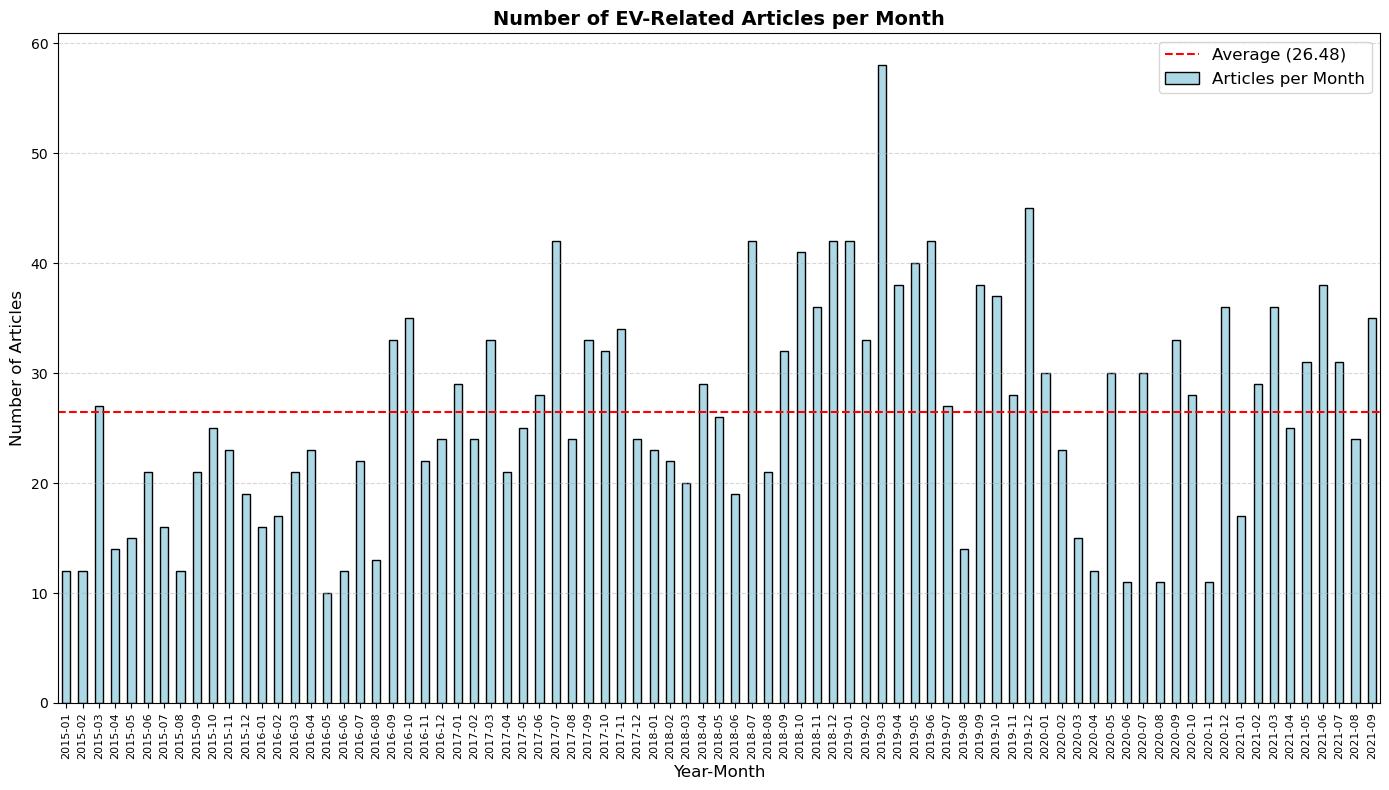

Totaal aantal artikelen: 2145


In [101]:
# Gemiddeld per maand
average_ev_articles_per_month = ev_articles_per_year.sum() / (len(ev_articles_per_year) * 12)
print(f"Gemiddeld aantal EV-gerelateerde artikelen per maand: {average_ev_articles_per_month:.2f}")

# Ensure 'published_time' is in datetime format
sorted_df['published_time'] = pd.to_datetime(sorted_df['published_time'], errors='coerce')

# Extract year and month from 'published_time'
sorted_df['year_month'] = sorted_df['published_time'].dt.to_period('M')

# Count the number of articles per month
articles_per_month = sorted_df['year_month'].value_counts().sort_index()

# Calculate the average number of articles per month
average_articles_per_month = articles_per_month.mean()

# Plot the data
plt.figure(figsize=(14, 8))
articles_per_month.plot(kind='bar', color='lightblue', edgecolor='black', label="Articles per Month")

# Add a horizontal line for the average
plt.axhline(y=average_articles_per_month, color='red', linestyle='--', label=f"Average ({average_articles_per_month:.2f})")

# Add labels, title, and formatting
plt.title("Number of EV-Related Articles per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
# Print the total number of articles
total_articles = len(sorted_df)
print(f"Totaal aantal artikelen: {total_articles}")


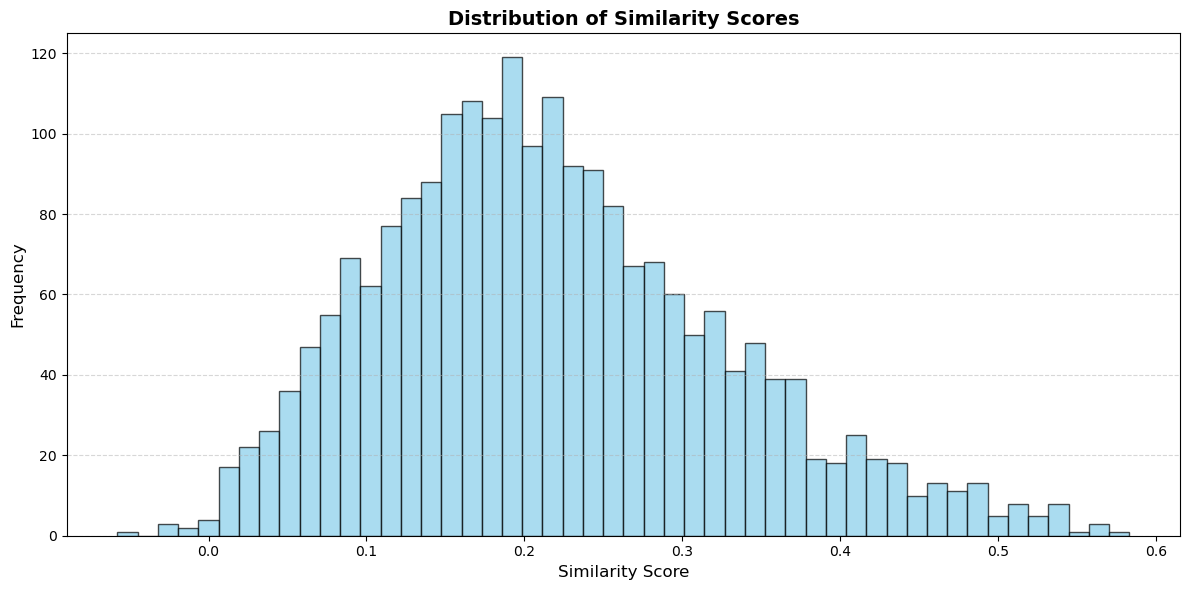

In [73]:
import matplotlib.pyplot as plt

# Plot similarity scores
plt.figure(figsize=(12, 6))
plt.hist(electric_cars_similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Similarity Scores", fontsize=14, fontweight="bold")
plt.xlabel("Similarity Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [74]:
# Calculate the average similarity score for the top 10 articles
top_10_articles = sorted_articles.head(10)
average_similarity_top_10 = top_10_articles['similarity'].mean()

# Print the titles and similarity scores of the top 10 articles
print("Top 10 Articles with Average Similarity:")
for idx, row in top_10_articles.iterrows():
    print(f"Title: {row['title']}")
    print(f"Similarity Score: {row['similarity']:.4f}")
    print(f"URL: {row['url']}\n")

# Print the average similarity score
print(f"Average Similarity Score of Top 10 Articles: {average_similarity_top_10:.4f}")

Top 10 Articles with Average Similarity:
Title: Zuinige auto's met subsidie gewild over de grens
Similarity Score: 0.5830
URL: https://nos.nl/artikel/2028957-zuinige-auto-s-met-subsidie-gewild-over-de-grens

Title: Tien procent van nieuwe auto's heeft stekker
Similarity Score: 0.5677
URL: https://nos.nl/artikel/2080280-tien-procent-van-nieuwe-auto-s-heeft-stekker

Title: Plan voor veel meer laadpalen in parkeergarages
Similarity Score: 0.5593
URL: https://nos.nl/artikel/2371152-plan-voor-veel-meer-laadpalen-in-parkeergarages

Title: Aantal stekkerauto's is verdubbeld
Similarity Score: 0.5588
URL: https://nos.nl/artikel/2101496-aantal-stekkerauto-s-is-verdubbeld

Title: Infographic: slaan we straks groene energie op in onze auto's?
Similarity Score: 0.5544
URL: https://nos.nl/op3/artikel/2197513-infographic-slaan-we-straks-groene-energie-op-in-onze-auto-s

Title: Nederland koploper groei volledig elektrische auto's
Similarity Score: 0.5417
URL: https://nos.nl/artikel/2214845-nederland-k

In [80]:
# Get the top 10 articles with the lowest similarity scores
top_10_lowest_similarity = sorted_articles.nsmallest(10, 'similarity')

# Print the details of the top 10 lowest similarity articles
print("Top 10 Articles with the Lowest Similarity Scores:")
for idx, row in top_10_lowest_similarity.iterrows():
    print(f"\nArticle {idx} similarity: {row['similarity']:.4f}")
    print(f"Title: {row['title']}")
    print(f"Description: {row['description']}")
    print(f"Content (snippet): {row['content'][:200]}...")
    print(f"URL: {row['url']}")


Top 10 Articles with the Lowest Similarity Scores:

Article 1821 similarity: -0.0576
Title: Horeca-ondernemer voor de rechter: 'Thuis meer risico op besmetting'
Description: In een kort geding eisen zeker 68 horecaondernemers onmiddellijke heropening van de horeca. De rechter doet vanmiddag uitspraak. 
Content (snippet): Horeca-ondernemer voor de rechter: 'Thuis meer risico op besmetting' De rechtbank in Den Haag doet vanmiddag om 16.00 uur uitspraak in het door meerdere horecaondernemers aangespannen kort geding. De ...
URL: https://nos.nl/artikel/2353064-horeca-ondernemer-voor-de-rechter-thuis-meer-risico-op-besmetting

Article 915 similarity: -0.0287
Title: Na bloedbad op boot bij Suriname opnieuw visser gedood
Description: Vrijdagnacht zijn ook een aantal boten overvallen. Slechts vier van de twintig bemanningsleden overleefden het.
Content (snippet): Na bloedbad op boot bij Suriname opnieuw visser gedood Op de Atlantische oceaan is vannacht opnieuw een vissersboot overvallen voor 

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


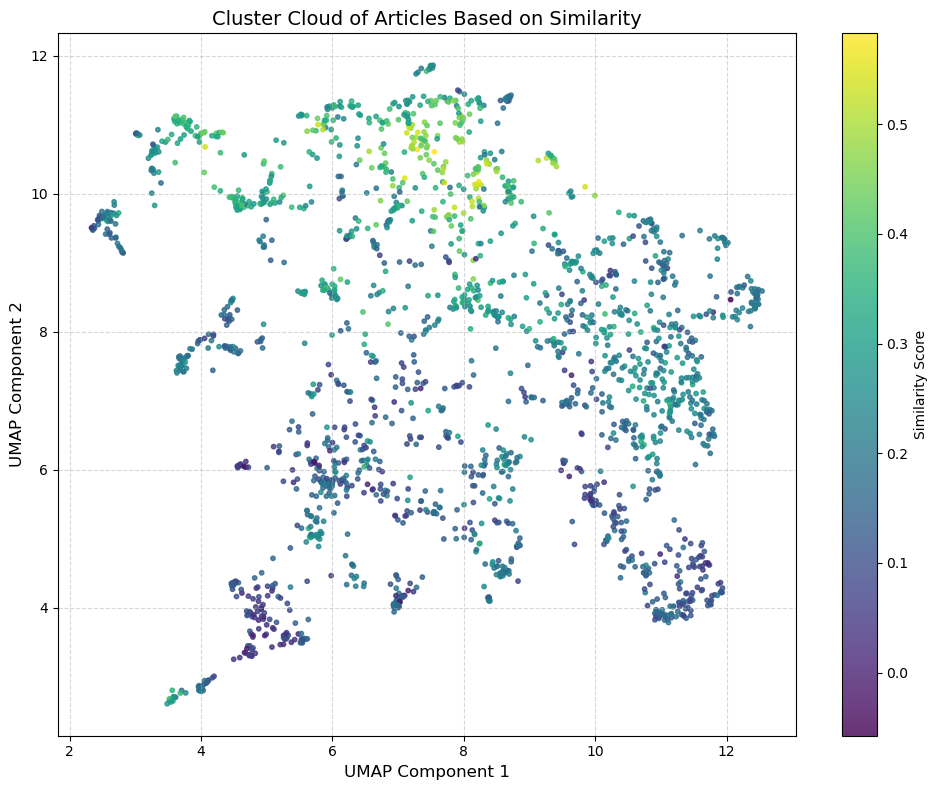

In [82]:
import umap  # Import the UMAP library for dimensionality reduction
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Reduce embeddings to 2D using UMAP
# UMAP is used to reduce the high-dimensional embeddings into 2D for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)  # Perform the dimensionality reduction

# Create a scatter plot with similarity scores as colors
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
scatter = plt.scatter(
    embedding_2d[:, 0],  # Use the first UMAP component for the x-axis
    embedding_2d[:, 1],  # Use the second UMAP component for the y-axis
    c=electric_cars_similarities,  # Color the points based on similarity scores
    cmap="viridis",  # Use the 'viridis' colormap for coloring
    s=10,  # Set the size of the points
    alpha=0.8  # Set the transparency of the points
)

# Add a color bar to indicate similarity scores
plt.colorbar(scatter, label="Similarity Score")  # Add a color bar with a label

# Add title and axis labels to the plot
plt.title("Cluster Cloud of Articles Based on Similarity", fontsize=14)  # Set the plot title
plt.xlabel("UMAP Component 1", fontsize=12)  # Label for the x-axis
plt.ylabel("UMAP Component 2", fontsize=12)  # Label for the y-axis

# Add grid lines to the plot for better readability
plt.grid(True, linestyle="--", alpha=0.5)  # Add a grid with dashed lines and some transparency

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()  # Display the scatter plot

In [145]:
from transformers import pipeline
import pandas as pd


# Laad de sentiment-analyse pipeline (werkt direct)
pipe = pipeline("text-classification", model="DTAI-KULeuven/robbert-v2-dutch-sentiment")

# Laad je dataframe
df_sorted = pd.read_csv(r"E:\Nieuw dataset\sorted_ev_articles.csv")

# Combineer tekstvelden tot één kolom voor sentimentanalyse
df_sorted['combined_text'] = (
    df_sorted['title'].fillna('') + ". " +
    df_sorted['description'].fillna('') + ". " +
    df_sorted['content'].fillna('')
)

# Pak een subset van 25 artikelen
df_subset = df_sorted.head(25).copy()

# Functie om sentimentlabel en score te halen via pipeline
def predict_sentiment(text):
    result = pipe(text, truncation=True)[0]
    return result['label'], result['score']

# Pas toe op de subset
results = df_subset['combined_text'].apply(predict_sentiment)
df_subset['sentiment_label'] = results.apply(lambda x: x[0])
df_subset['sentiment_score'] = results.apply(lambda x: x[1])



# Opslaan
#df_subset.to_csv("ev_subset_with_sentiment.csv", index=False, encoding="utf-8")




display(df_subset[['title', 'url', 'sentiment_label', 'sentiment_score']])



,title,url,sentiment_label,sentiment_score
0,Zuinige auto's met subsidie gewild over de grens,https://nos.nl/artikel/2028957-zuinige-auto-s-...,Negative,0.504026
1,Tien procent van nieuwe auto's heeft stekker,https://nos.nl/artikel/2080280-tien-procent-va...,Positive,0.995917
2,Plan voor veel meer laadpalen in parkeergarages,https://nos.nl/artikel/2371152-plan-voor-veel-...,Positive,0.998279
3,Aantal stekkerauto's is verdubbeld,https://nos.nl/artikel/2101496-aantal-stekkera...,Positive,0.501588
4,Infographic: slaan we straks groene energie op...,https://nos.nl/op3/artikel/2197513-infographic...,Positive,0.775774
5,Nederland koploper groei volledig elektrische ...,https://nos.nl/artikel/2214845-nederland-koplo...,Negative,0.998914
6,Van Veldhoven: beschikbaarheid van laadpalen m...,https://nos.nl/artikel/2351993-van-veldhoven-b...,Positive,0.992786
7,Automaker Tesla wil het energie-gebruik in de ...,https://nos.nl/artikel/2033368-automaker-tesla...,Positive,0.875450
8,Shell stapt in markt voor opladen elektrische ...,https://nos.nl/artikel/2132174-shell-stapt-in-...,Negative,0.507297
9,'Tekort aan laadpunten voor elektrische auto's...,https://nos.nl/nieuwsuur/artikel/2263376-tekor...,Positive,0.998984


### Google collab code 


#  Laad DataFrame vanuit je Drive
csv_path = "/content/EV_related_articles.csv"
df = pd.read_csv(csv_path)

#  Combineer tekstvelden tot één kolom
df['combined_text'] = (
    df['title'].fillna('') + ". " +
    df['description'].fillna('') + ". " +
    df['content'].fillna('')
)

#  Functie voor sentimentanalyse
def predict_sentiment(text):
    result = pipe(text, truncation=True)[0]
    return result['label'], result['score']

#  Pas sentimentanalyse toe op de volledige dataset
results = df['combined_text'].apply(predict_sentiment)
df['sentiment_label'] = results.apply(lambda x: x[0])
df['sentiment_score'] = results.apply(lambda x: x[1])

#  Opslaan naar Drive
output_path = "/content/drive/MyDrive/Total_EV_with_sentiment.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print(f" Bestand opgeslagen in: {output_path}")

#  Toon voorbeeld
display(df) 

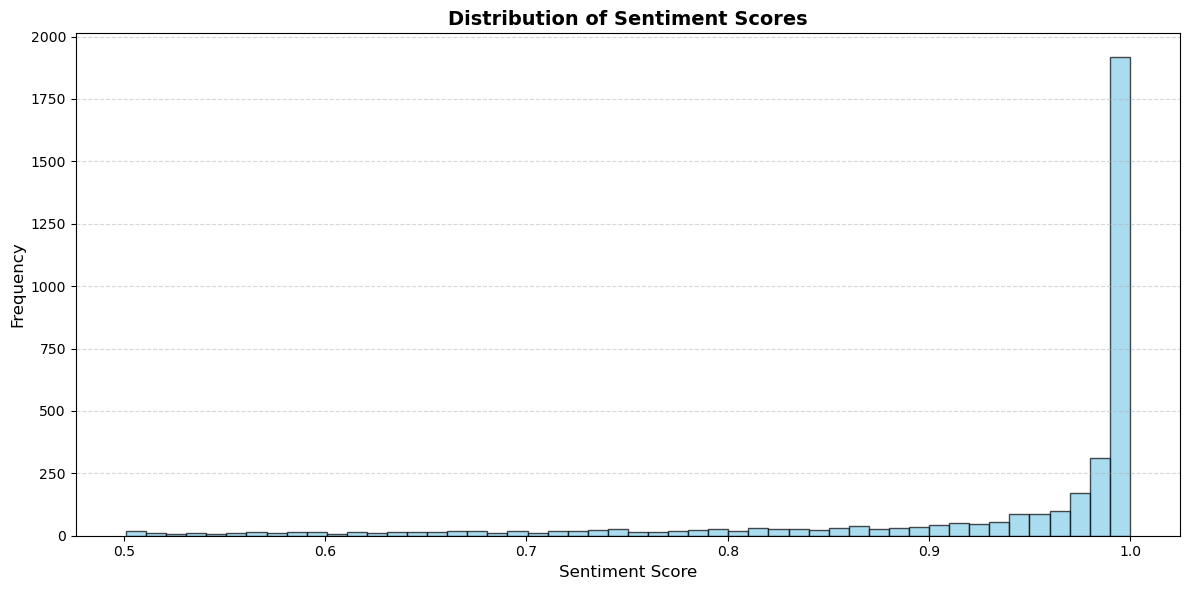

In [147]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the dataset
file_path = r"E:\Nieuw dataset\Total_EV_with_sentiment.csv"
df = pd.read_csv(file_path)

# Ensure sentiment_score column is numeric
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
plt.hist(df['sentiment_score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Sentiment Scores", fontsize=14, fontweight="bold")
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [154]:
# Display the DataFrame with selected columns
display(df[['title', 'sentiment_label', 'sentiment_score', 'url']])

,title,sentiment_label,sentiment_score,url
0,Verkoop nieuwe auto's stevent af op laagterecord,Negative,0.798624,https://nos.nl/artikel/2011357-verkoop-nieuwe-...
1,De stroom 02/01,Negative,0.694714,https://nos.nl/op3/liveblog/2011449-de-stroom-...
2,Wind en hitte bedreigen bosbrandgebied Australië,Positive,0.998884,https://nos.nl/artikel/2011782-wind-en-hitte-b...
3,Hoe gegijzelden buiten schot bleven in Parijs,Positive,0.995606,https://nos.nl/artikel/2012612-hoe-gegijzelden...
4,Stroomstoring Rotterdam automatisch opgelost,Positive,0.999518,https://nos.nl/artikel/2012942-stroomstoring-r...
...,...,...,...,...
3611,Den Haag ontvangt vicepremier China op het hoo...,Positive,0.998076,https://nos.nl/l/2552983
3612,"Dode in Ierland na Éowyn, zwaarste storm sinds...",Positive,0.978364,https://nos.nl/l/2553090
3613,"Regionale industrie krijgt geen stroom, maar b...",Negative,0.997568,https://nos.nl/l/2553436
3614,"Oost-Congo al langer toneel van strijd, vooral...",Positive,0.997544,https://nos.nl/l/2553522


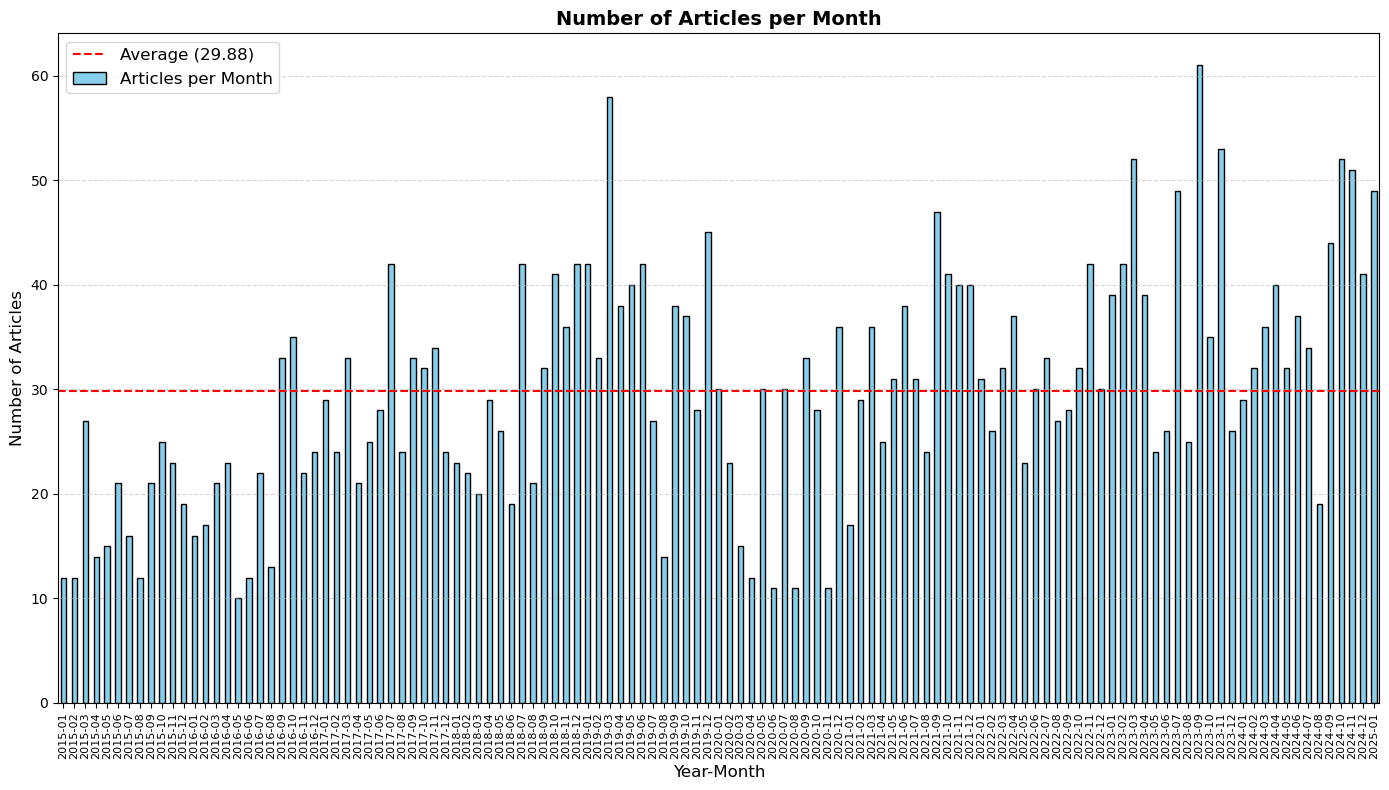

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
# Convert 'published_time' to datetime format
df['published_time'] = pd.to_datetime(df['published_time'], format='%Y/%m/%d')

# Extract year and month from 'published_time' and create 'year_month' column
df['year_month'] = df['published_time'].dt.to_period('M')


# Count the number of articles per month
articles_per_month = df['year_month'].value_counts().sort_index()

# Calculate the average number of articles per month
average_articles_per_month = articles_per_month.mean()

# Plot the data
plt.figure(figsize=(14, 8))
articles_per_month.plot(kind='bar', color='skyblue', edgecolor='black', label="Articles per Month")

# Add a horizontal line for the average
plt.axhline(y=average_articles_per_month, color='red', linestyle='--', label=f"Average ({average_articles_per_month:.2f})")

# Add labels, title, and formatting
plt.title("Number of Articles per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Zorg dat published_time als datetime wordt geïnterpreteerd
df['published_time'] = pd.to_datetime(df['published_time'], errors='coerce')

# Extract year-month in 'YYYY/MM'-formaat
df['year_month'] = df['published_time'].dt.strftime('%Y/%m')

# Bereken gemiddeld sentiment per maand
avg_sentiment_per_month = (
    df.groupby('year_month')['sentiment_score']
    .mean()
    .reset_index()
)

# Herbenoem kolommen
avg_sentiment_per_month.columns = ['Year-Month', 'Average Sentiment Score']

# Opslaan naar CSV
avg_sentiment_per_month.to_csv(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\average_sentiment_per_month.csv", index=False, encoding='utf-8')

print(" Bestand 'average_sentiment_per_month.csv' succesvol opgeslagen.")


✅ Bestand 'average_sentiment_per_month.csv' succesvol opgeslagen.


C:\Users\dylan\AppData\Local\Temp\ipykernel_4664\423196171.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  avg_sentiment_per_month['Year-Month'] = pd.to_datetime(avg_sentiment_per_month['Year-Month'])


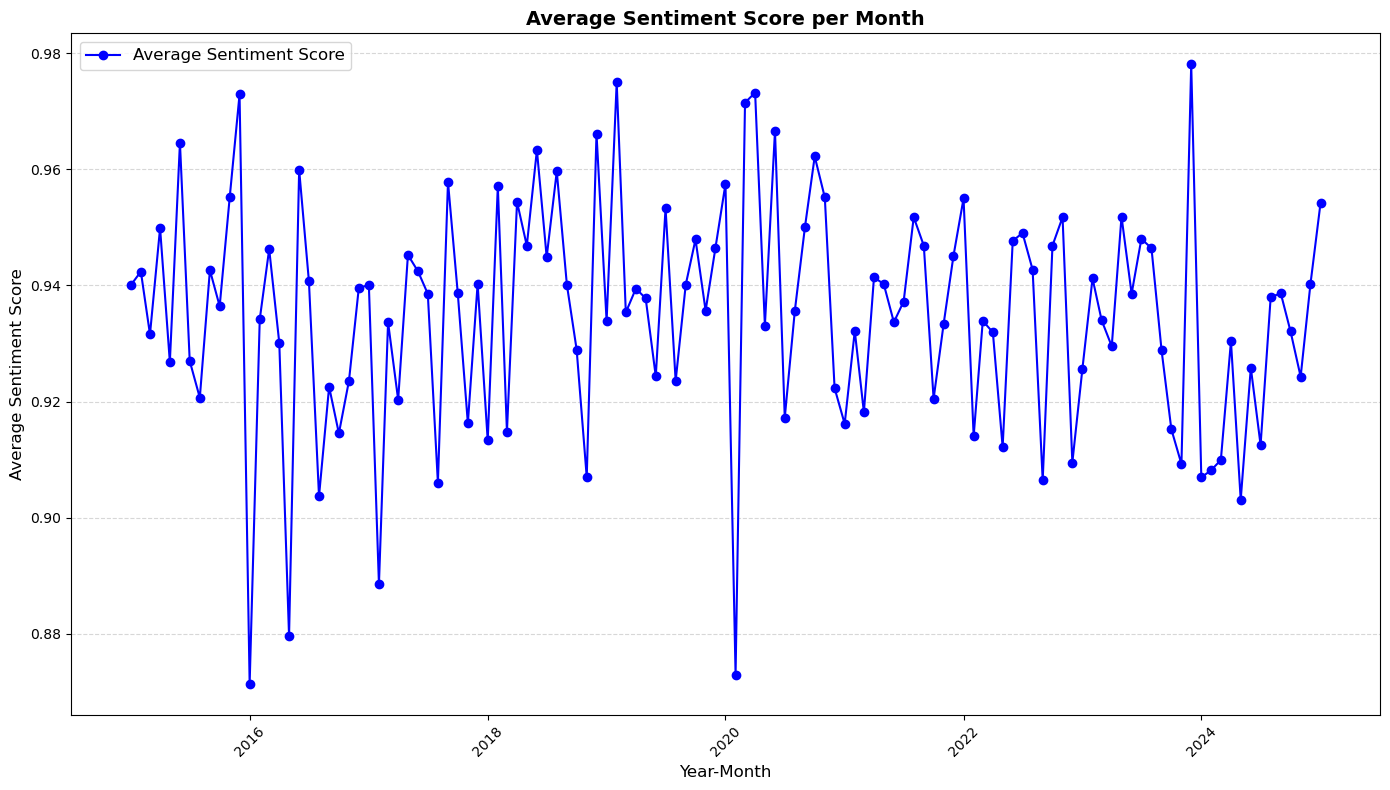

In [155]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the dataset containing average sentiment per month
file_path = r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\average_sentiment_per_month.csv"
avg_sentiment_per_month = pd.read_csv(file_path)

# Ensure 'Year-Month' is in datetime format for proper plotting
avg_sentiment_per_month['Year-Month'] = pd.to_datetime(avg_sentiment_per_month['Year-Month'])

# Plot the average sentiment score per month
plt.figure(figsize=(14, 8))
plt.plot(avg_sentiment_per_month['Year-Month'], avg_sentiment_per_month['Average Sentiment Score'], 
         marker='o', color='blue', label="Average Sentiment Score")

# Add labels, title, and formatting
plt.title("Average Sentiment Score per Month", fontsize=14, fontweight="bold")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()